# Import  Modules

In [1]:
import os 
import pandas as pd
import numpy as np
import seaborn as sns
#pip install pandas-profiling
import pandas_profiling
import matplotlib.pyplot as plt
%matplotlib inline

pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)
from sklearn.preprocessing import OrdinalEncoder,LabelEncoder,OrdinalEncoder,OneHotEncoder
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

seed=0

from sklearn.metrics import mean_squared_error,accuracy_score, roc_auc_score,f1_score,confusion_matrix
from sklearn.preprocessing import OrdinalEncoder,LabelEncoder,OneHotEncoder
from sklearn.preprocessing import StandardScaler, RobustScaler,MinMaxScaler,PolynomialFeatures
from sklearn.model_selection import train_test_split, KFold

from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor
from catboost import CatBoostRegressor,CatBoostClassifier
from lightgbm import LGBMRegressor,LGBMClassifier
from xgboost import XGBRegressor,XGBClassifier

C:\Users\PC\AppData\Local\Temp\ipykernel_10344\2334158970.py:6: DeprecationWarning: `import pandas_profiling` is going to be deprecated by April 1st. Please use `import ydata_profiling` instead.
  import pandas_profiling


# Read the Datasets

#### VALIDATION

In [2]:
# Load the testing data from the "test.csv" file and store it in the "test" DataFrame
test = pd.read_csv("test.csv")

# Convert the "endTime" column in the "test" DataFrame to datetime format
test['endTime'] = pd.to_datetime(test['endTime'])

# Print the shape (number of rows and columns) of the "test" DataFrame
print(test.shape)

# Display the first few rows of the "test" DataFrame
test.head()

(175150, 11)


,NE ID,endTime,access_success_rate,resource_utilition_rate,TA,bler,cqi,mcs,data_rate,fault_duration,relation
0,B0017-25_24,2023-02-20 06:00:00,99.714558,8.678,3.715410,7.653169,5.964988,5.403557,6.815789,0.0,0.000000
1,B0017-25_24,2023-02-20 07:00:00,99.927484,24.264,3.145402,10.015796,6.141206,6.544645,6.777114,0.0,0.000000
2,B0017-25_24,2023-02-20 08:00:00,99.357688,84.004,2.923368,14.209819,5.582824,5.667775,1.175289,0.0,0.000000
3,B0017-25_24,2023-02-20 09:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,301.0,0.654162
4,B0017-25_25,2023-02-20 19:00:00,99.264875,93.086,2.732594,16.947693,5.475508,4.719393,0.522540,0.0,0.000000


#### TRAIN

In [3]:
# Load the training data from the "train.csv" file and store it in the "train" DataFrame
train = pd.read_csv("train.csv")

# Convert the "endTime" column in the "train" DataFrame to datetime format
train['endTime'] = pd.to_datetime(train['endTime'])

# Print the shape (number of rows and columns) of the "train" DataFrame
print(train.shape)

# Retrieve the last 1000 rows from the "train" DataFrame and display rows 80 to 84 from that subset
train.tail(1000)[80:85]

(908922, 11)


,NE ID,endTime,access_success_rate,resource_utilition_rate,TA,bler,cqi,mcs,data_rate,fault_duration,relation
908002,B0729-13_1,2023-02-27 23:00:00,99.975315,44.245,3.244196,9.938242,9.106802,11.470092,19.380749,0.0,0.00
908003,B0729-13_1,2023-02-28 00:00:00,100.000000,35.853,3.175133,10.320035,9.238970,11.740756,21.438768,0.0,0.00
908004,B0729-13_1,2023-02-28 01:00:00,100.000000,31.238,3.196790,9.079722,9.034929,9.725438,22.493861,950.0,0.99
908005,B0729-13_1,2023-02-28 02:00:00,99.547511,1.728,3.338323,6.922154,9.874873,8.773274,21.961071,209.0,0.99
908006,B0729-15_1,2023-02-09 01:00:00,99.977350,29.442,3.055147,10.424411,7.210986,9.657070,8.758230,0.0,0.00


#### Combine Train and Test
-For easier manipulation

In [4]:
# Create a new column "predict_rows" in the train DataFrame and set all initial values to 0
train["predict_rows"] = 0

# Create a new column "predict_rows" in the test DataFrame and set all initial values to 0
test["predict_rows"] = 0

# Set the values in the "predict_rows" column of the test DataFrame to 1
# for rows where the "fault_duration" column has a value greater than 0 for easy retrieval later
test.loc[test["fault_duration"] > 0, "predict_rows"] = 1

# Concatenate the train and test DataFrames into a single DataFrame called "combined_df"
combined_df = pd.concat([train, test]) 

# Sort the combined DataFrame by "NE ID" and "endTime" columns in ascending order
combined_df.sort_values(by=["NE ID", "endTime"], inplace=True)

# Calculate and print the length of the combined DataFrame
print(len(combined_df))

# Display the rows in the combined DataFrame where the "NE ID" is "B0017-13_8"
#combined_df[combined_df["NE ID"]=="B0017-13_8"]

1084072


# Create Target variable
-If data rate of previous non fault row is greater than data rate of the fault row , then the label is 1 else 0 and that's our target.

In [5]:
# Calculate the percentage change in the 'data_rate' column for each group of 'NE ID'
combined_df['data_roc'] = combined_df.groupby('NE ID', group_keys=False)['data_rate'].apply(lambda x: x.pct_change())

# Define a function to determine the trend of data rate change
def data_rate_change(group):
    # Create a new column 'data_rate_t+1_trend' based on the percentage change
    # If the percentage change is greater than 0, assign trend as 0 (no change or increase)
    # Otherwise, assign trend as 1 (decrease)
    group['data_rate_t+1_trend'] = group['data_roc'].apply(lambda x: 0 if x > 0 else 1)
    return group

# Group the data by 'NE ID', apply the 'data_rate_change' function, and maintain the structure
train_grouped = combined_df.groupby('NE ID', as_index=False, group_keys=False).apply(data_rate_change)

# Reset the index of the DataFrame after applying the transformation
combined_df = train_grouped.reset_index(drop=True)

# Display the rows in the combined DataFrame where the "NE ID" is "B0017-13_8"
combined_df[combined_df["NE ID"]=="B0017-13_8"]

,NE ID,endTime,access_success_rate,resource_utilition_rate,TA,bler,cqi,mcs,data_rate,fault_duration,relation,predict_rows,data_roc,data_rate_t+1_trend
37561,B0017-13_8,2023-02-17 05:00:00,100.000000,1.054,3.035211,1.884315,10.792361,2.912705,89.909177,0.0,0.000000,0,NaN,1
37562,B0017-13_8,2023-02-17 06:00:00,100.000000,1.702,2.638554,5.715271,11.273952,9.487271,48.475408,0.0,0.000000,0,-0.460840,1
37563,B0017-13_8,2023-02-17 07:00:00,99.747899,14.521,2.963437,11.297409,8.910144,9.713915,8.450350,0.0,0.000000,0,-0.825678,1
37564,B0017-13_8,2023-02-17 08:00:00,99.829787,36.649,2.542375,12.062139,7.125136,7.467310,2.897868,46.0,0.654162,0,-0.657071,1
37565,B0017-13_8,2023-02-17 09:00:00,99.860807,58.506,2.412703,12.039579,6.916188,7.704837,2.397028,57.0,0.654162,0,-0.172830,1
37566,B0017-13_8,2023-02-17 10:00:00,99.844781,50.280,2.428769,12.145683,7.321369,8.263317,3.663715,2938.0,0.654162,0,0.528440,0
37567,B0017-13_8,2023-02-17 11:00:00,99.942639,46.411,2.510660,12.264153,7.599301,8.270461,5.753700,1089.0,0.654162,0,0.570455,0
37568,B0017-13_8,2023-02-17 12:00:00,90.738391,60.956,2.461951,12.093170,7.612720,9.045568,6.245630,25.0,0.654162,0,0.085498,0


# Data From Previous Hour to predict the data for the current hour
-Achieved through shifting

In [6]:
# Create a list of columns excluding those specified in the exclusion list
cols = [col for col in train.columns if col not in ["NE ID", "endTime", "fault_duration", "relation",\
                                                    'data_rate_t+1_trend', "predict_rows"]]

# Assign a unique group ID to each 'NE ID' group
combined_df['Group_ID'] = combined_df.groupby('NE ID').ngroup() 

# Sort the combined DataFrame by 'Group_ID' and 'endTime'
combined_df.sort_values(by=['Group_ID', 'endTime'], inplace=True) 

# Shift the specified columns within each 'Group_ID' to align with previous time steps
shifted_data = combined_df.groupby(['Group_ID'], as_index=False)[cols].shift()

# Drop the original columns and the 'Group_ID' column
combined_df.drop(columns=cols+['Group_ID'], inplace=True)

# Concatenate the original combined DataFrame with the shifted data
combined_df = pd.concat([combined_df, shifted_data], axis=1)

# Display the rows in the combined DataFrame where the "NE ID" is "B0017-13_8"
combined_df[combined_df["NE ID"] == "B0017-13_8"]

,NE ID,endTime,fault_duration,relation,predict_rows,data_roc,data_rate_t+1_trend,access_success_rate,resource_utilition_rate,TA,bler,cqi,mcs,data_rate
37561,B0017-13_8,2023-02-17 05:00:00,0.0,0.000000,0,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
37562,B0017-13_8,2023-02-17 06:00:00,0.0,0.000000,0,-0.460840,1,100.000000,1.054,3.035211,1.884315,10.792361,2.912705,89.909177
37563,B0017-13_8,2023-02-17 07:00:00,0.0,0.000000,0,-0.825678,1,100.000000,1.702,2.638554,5.715271,11.273952,9.487271,48.475408
37564,B0017-13_8,2023-02-17 08:00:00,46.0,0.654162,0,-0.657071,1,99.747899,14.521,2.963437,11.297409,8.910144,9.713915,8.450350
37565,B0017-13_8,2023-02-17 09:00:00,57.0,0.654162,0,-0.172830,1,99.829787,36.649,2.542375,12.062139,7.125136,7.467310,2.897868
37566,B0017-13_8,2023-02-17 10:00:00,2938.0,0.654162,0,0.528440,0,99.860807,58.506,2.412703,12.039579,6.916188,7.704837,2.397028
37567,B0017-13_8,2023-02-17 11:00:00,1089.0,0.654162,0,0.570455,0,99.844781,50.280,2.428769,12.145683,7.321369,8.263317,3.663715
37568,B0017-13_8,2023-02-17 12:00:00,25.0,0.654162,0,0.085498,0,99.942639,46.411,2.510660,12.264153,7.599301,8.270461,5.753700


# Create Feature Fault

In [7]:
# Define a function to create a fault label based on the "fault_duration" column
def create_fault_label(row):
    # If the "fault_duration" is greater than 0, label it as 1 (indicating fault)
    # Otherwise, label it as 0 (indicating no fault)
    if row["fault_duration"] > 0:
        return 1
    else:
        return 0

# Apply the "create_fault_label" function to each row in the DataFrame using axis=1
combined_df["fault"] = combined_df.apply(create_fault_label, axis=1)

# Display the rows in the combined DataFrame where the "NE ID" is "B0017-13_8"
combined_df[combined_df["NE ID"] == "B0017-13_8"]

,NE ID,endTime,fault_duration,relation,predict_rows,data_roc,data_rate_t+1_trend,access_success_rate,resource_utilition_rate,TA,bler,cqi,mcs,data_rate,fault
37561,B0017-13_8,2023-02-17 05:00:00,0.0,0.000000,0,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
37562,B0017-13_8,2023-02-17 06:00:00,0.0,0.000000,0,-0.460840,1,100.000000,1.054,3.035211,1.884315,10.792361,2.912705,89.909177,0
37563,B0017-13_8,2023-02-17 07:00:00,0.0,0.000000,0,-0.825678,1,100.000000,1.702,2.638554,5.715271,11.273952,9.487271,48.475408,0
37564,B0017-13_8,2023-02-17 08:00:00,46.0,0.654162,0,-0.657071,1,99.747899,14.521,2.963437,11.297409,8.910144,9.713915,8.450350,1
37565,B0017-13_8,2023-02-17 09:00:00,57.0,0.654162,0,-0.172830,1,99.829787,36.649,2.542375,12.062139,7.125136,7.467310,2.897868,1
37566,B0017-13_8,2023-02-17 10:00:00,2938.0,0.654162,0,0.528440,0,99.860807,58.506,2.412703,12.039579,6.916188,7.704837,2.397028,1
37567,B0017-13_8,2023-02-17 11:00:00,1089.0,0.654162,0,0.570455,0,99.844781,50.280,2.428769,12.145683,7.321369,8.263317,3.663715,1
37568,B0017-13_8,2023-02-17 12:00:00,25.0,0.654162,0,0.085498,0,99.942639,46.411,2.510660,12.264153,7.599301,8.270461,5.753700,1


# Reduce the Data 

#### ONLY PICK THE FIRST ROW OF DURATION>0
-It was found that some rows had more than one instance of fault. For simplicity, I only pick the first instance of fault and ignore the rest.

In [8]:
# Print the length of the combined DataFrame before the filtering process
before_filtering_length = len(combined_df)
print("Before:", before_filtering_length)

# Group the DataFrame by 'NE ID'
grouped = combined_df.groupby('NE ID')

# Define a function to filter rows based on specific conditions
def filter_rows(group):
    # Select rows with 'fault_duration' equal to 0
    rows_with_fault_duration_zero = group[group['fault_duration'] == 0]

    # Find the index of the first row with 'fault_duration' greater than 0
    first_fault_duration_gt_zero_index = group[group['fault_duration'] > 0].index[0]

    # Select the row corresponding to the first fault duration greater than 0
    row_with_first_fault_duration_gt_zero = group.loc[first_fault_duration_gt_zero_index:\
                                                      first_fault_duration_gt_zero_index]

    # Concatenate the selected rows and return
    return pd.concat([rows_with_fault_duration_zero, row_with_first_fault_duration_gt_zero])

# Apply the filtering function to each group and reset the index
combined_df = grouped.apply(filter_rows).reset_index(drop=True)

# Print the length of the combined DataFrame after the filtering process
after_filtering_length = len(combined_df)
print("After:", after_filtering_length)

# Display the rows in the combined DataFrame where the "NE ID" is "B0017-13_8"
combined_df[combined_df["NE ID"] == "B0017-13_8"]

Before: 1084072
After: 995544


,NE ID,endTime,fault_duration,relation,predict_rows,data_roc,data_rate_t+1_trend,access_success_rate,resource_utilition_rate,TA,bler,cqi,mcs,data_rate,fault
35624,B0017-13_8,2023-02-17 05:00:00,0.0,0.000000,0,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
35625,B0017-13_8,2023-02-17 06:00:00,0.0,0.000000,0,-0.460840,1,100.000000,1.054,3.035211,1.884315,10.792361,2.912705,89.909177,0
35626,B0017-13_8,2023-02-17 07:00:00,0.0,0.000000,0,-0.825678,1,100.000000,1.702,2.638554,5.715271,11.273952,9.487271,48.475408,0
35627,B0017-13_8,2023-02-17 08:00:00,46.0,0.654162,0,-0.657071,1,99.747899,14.521,2.963437,11.297409,8.910144,9.713915,8.450350,1


#### DROP ALL ROWS WITH 0 IN THE 'DATA_RATE' COLUMN AND 0 IN THE 'FAULT_DURATION' COLUMN
-In typical scenarios, 'data_rate' would be 0 during faults; thus, deviations signal anomalies. After inspecting datataset, it was found that some had data_rate 0 and fault duration was also 0. Indicating an incosistency

In [9]:
# Print the length of the combined DataFrame before the filtering process
before_filtering_length = len(combined_df)
print("Before:", before_filtering_length)

# Filter the DataFrame based on conditions:
# Select rows where 'data_rate' is not equal to 0 OR 'fault_duration' is not equal to 0. 
# In typical scenarios, 'data_rate' would be 0 during faults; thus, deviations signal anomalies.
combined_df = combined_df.loc[(combined_df['data_rate'] != 0) | (combined_df['fault_duration'] != 0)]

# Print the length of the combined DataFrame after the filtering process
after_filtering_length = len(combined_df)
print("After:", after_filtering_length)

# Display the rows in the combined DataFrame where the "NE ID" is "B0017-13_8"
#combined_df[combined_df["NE ID"] == "B0017-13_8"]

Before: 995544
After: 957480


#### DROP THE ROWS AFFECTED BY SHIFTING
-These rows are the first row of each ID and now contain NAN values after shifting the previous day.

In [10]:
# Print the length of the combined DataFrame before the filtering process
before_filtering_length = len(combined_df)
print("Before:", before_filtering_length)

# Create a mask to identify rows where "NE ID" changes compared to the previous row
mask = combined_df['NE ID'] != combined_df['NE ID'].shift()

# Apply the mask to filter out rows where "NE ID" changes
combined_df = combined_df[~mask]

# Print the length of the combined DataFrame after the filtering process
after_filtering_length = len(combined_df)
print("After:", after_filtering_length)

Before: 957480
After: 948292


# Create Time Features
-The hour proved to be very important feature here!

In [11]:
# Create a new column "hour" in the combined DataFrame representing the hour of the day
combined_df["hour"] = combined_df["endTime"].dt.hour

# Create a new column "month" in the combined DataFrame representing the month of the year
combined_df["month"] = combined_df["endTime"].dt.month

# Create a new column "day_of_week" in the combined DataFrame representing the day of the week (0: Monday, 6: Sunday)
combined_df["day_of_week"] = combined_df["endTime"].dt.dayofweek

# Create a new column "is_weekend" in the combined DataFrame to indicate whether the day is a weekend (1) or not (0)
combined_df["is_weekend"] = combined_df["day_of_week"].apply(lambda x: 1 if x < 5 else 0)

# Display the rows in the combined DataFrame where the "NE ID" is "B0017-13_8"
combined_df[combined_df["NE ID"]=="B0017-13_8"]

,NE ID,endTime,fault_duration,relation,predict_rows,data_roc,data_rate_t+1_trend,access_success_rate,resource_utilition_rate,TA,bler,cqi,mcs,data_rate,fault,hour,month,day_of_week,is_weekend
35625,B0017-13_8,2023-02-17 06:00:00,0.0,0.000000,0,-0.460840,1,100.000000,1.054,3.035211,1.884315,10.792361,2.912705,89.909177,0,6,2,4,1
35626,B0017-13_8,2023-02-17 07:00:00,0.0,0.000000,0,-0.825678,1,100.000000,1.702,2.638554,5.715271,11.273952,9.487271,48.475408,0,7,2,4,1
35627,B0017-13_8,2023-02-17 08:00:00,46.0,0.654162,0,-0.657071,1,99.747899,14.521,2.963437,11.297409,8.910144,9.713915,8.450350,1,8,2,4,1


In [12]:
# Create a new column "hour_day_interaction" by multiplying the 'hour' and 'day_of_week' columns
combined_df['hour_day_interaction'] = combined_df['hour'] * combined_df['day_of_week']

# Create a new column "hour_month_interaction" by multiplying the 'hour' and 'month' columns
combined_df['hour_month_interaction'] = combined_df['hour'] * combined_df['month']

# Create a new column "hour_weekend_interaction" by multiplying the 'hour' and 'is_weekend' columns
combined_df['hour_weekend_interaction'] = combined_df['hour'] * combined_df['is_weekend']

# Create a new column "hour_day_month_interaction" by multiplying the 'hour', 'day_of_week', and 'month' columns
combined_df['hour_day_month_interaction'] = combined_df['hour'] * combined_df['day_of_week'] * combined_df['month']

# Define a custom function to determine the period of the day based on the hour
def get_period_of_day(hour):
    if 0 <= hour < 6:
        return 'night'
    elif 6 <= hour < 12:
        return 'morning'
    elif 12 <= hour < 18:
        return 'afternoon'
    else:
        return 'evening'

# Apply the custom function to create the 'period_of_day' feature
combined_df['period_of_day'] = combined_df['hour'].apply(get_period_of_day)

#Create the interaction feature 'hour_period_interaction' by multiplying 'hour' with a weightin based on 'period_of_day'
combined_df['hour_period_interaction'] = combined_df['hour'] * combined_df['period_of_day'].map({
    'night': 1,
    'morning': 4,
    'afternoon': 3,
    'evening': 2
})

# Display the rows in the combined DataFrame where the "NE ID" is "B0017-13_8"
combined_df[combined_df["NE ID"] == "B0017-13_8"]

,NE ID,endTime,fault_duration,relation,predict_rows,data_roc,data_rate_t+1_trend,access_success_rate,resource_utilition_rate,TA,bler,cqi,mcs,data_rate,fault,hour,month,day_of_week,is_weekend,hour_day_interaction,hour_month_interaction,hour_weekend_interaction,hour_day_month_interaction,period_of_day,hour_period_interaction
35625,B0017-13_8,2023-02-17 06:00:00,0.0,0.000000,0,-0.460840,1,100.000000,1.054,3.035211,1.884315,10.792361,2.912705,89.909177,0,6,2,4,1,24,12,6,48,morning,24
35626,B0017-13_8,2023-02-17 07:00:00,0.0,0.000000,0,-0.825678,1,100.000000,1.702,2.638554,5.715271,11.273952,9.487271,48.475408,0,7,2,4,1,28,14,7,56,morning,28
35627,B0017-13_8,2023-02-17 08:00:00,46.0,0.654162,0,-0.657071,1,99.747899,14.521,2.963437,11.297409,8.910144,9.713915,8.450350,1,8,2,4,1,32,16,8,64,morning,32


# Length of Dataframe per ID Feature

In [13]:
# Calculate the count of occurrences for each 'NE ID' in the combined DataFrame
fault_duration_count = combined_df['NE ID'].value_counts().reset_index()

# Rename the columns to 'NE ID' and 'length_of_df' for better clarity
fault_duration_count.columns = ['NE ID', 'length_of_df']

# Merge the calculated features with the original combined DataFrame based on 'NE ID'
# This adds the 'length_of_df' column to the combined DataFrame
combined_df = combined_df.merge(fault_duration_count, on='NE ID', how='left')

# Display the rows in the combined DataFrame where the "NE ID" is "B0017-13_8"
combined_df[combined_df["NE ID"] == "B0017-13_8"]

,NE ID,endTime,fault_duration,relation,predict_rows,data_roc,data_rate_t+1_trend,access_success_rate,resource_utilition_rate,TA,bler,cqi,mcs,data_rate,fault,hour,month,day_of_week,is_weekend,hour_day_interaction,hour_month_interaction,hour_weekend_interaction,hour_day_month_interaction,period_of_day,hour_period_interaction,length_of_df
33858,B0017-13_8,2023-02-17 06:00:00,0.0,0.000000,0,-0.460840,1,100.000000,1.054,3.035211,1.884315,10.792361,2.912705,89.909177,0,6,2,4,1,24,12,6,48,morning,24,3
33859,B0017-13_8,2023-02-17 07:00:00,0.0,0.000000,0,-0.825678,1,100.000000,1.702,2.638554,5.715271,11.273952,9.487271,48.475408,0,7,2,4,1,28,14,7,56,morning,28,3
33860,B0017-13_8,2023-02-17 08:00:00,46.0,0.654162,0,-0.657071,1,99.747899,14.521,2.963437,11.297409,8.910144,9.713915,8.450350,1,8,2,4,1,32,16,8,64,morning,32,3


# Interaction Features of the KPI's

In [14]:
# Calculate ratios between KPIs
combined_df['access_resource_ratio'] = combined_df['access_success_rate'] /(combined_df['resource_utilition_rate']+1e-9)
combined_df['bler_cqi_ratio'] = combined_df['bler'] / (combined_df['cqi']+1e-9)
combined_df['mcs_cqi_ratio'] = combined_df['mcs'] / (combined_df['cqi']+1e-9)

# Calculate differences between KPIs
combined_df['data_rate_access_difference'] = combined_df['data_rate'] - combined_df['access_success_rate']
combined_df['cqi_bler_difference'] = combined_df['cqi'] - combined_df['bler']

# Calculate products of KPIs
combined_df['cqi_bler_product'] = combined_df['cqi'] * combined_df['bler']
combined_df['access_mcs_product'] = combined_df['access_success_rate'] * combined_df['mcs']

# Calculate more features based on existing KPIs
combined_df['access_mcs_ratio'] = combined_df['access_success_rate'] / (combined_df['mcs'] + 1e-9)
combined_df['bler_mcs_ratio'] = combined_df['bler'] / (combined_df['mcs'] + 1e-9)
combined_df['data_rate_resource_ratio'] = combined_df['data_rate'] / (combined_df['resource_utilition_rate'] + 1e-9)

combined_df['cqi_minus_bler'] = combined_df['cqi'] - combined_df['bler']
combined_df['cqi_minus_mcs'] = combined_df['cqi'] - combined_df['mcs']
combined_df['access_rate_difference'] = combined_df['access_success_rate'] - combined_df['data_rate']
combined_df['resource_bler_product'] = combined_df['resource_utilition_rate'] * combined_df['bler']
combined_df['data_rate_minus_mcs'] = combined_df['data_rate'] - combined_df['mcs']

# Display the rows in the combined DataFrame where the "NE ID" is "B0017-13_8"
combined_df[combined_df["NE ID"] == "B0017-13_8"]

,NE ID,endTime,fault_duration,relation,predict_rows,data_roc,data_rate_t+1_trend,access_success_rate,resource_utilition_rate,TA,bler,cqi,mcs,data_rate,fault,hour,month,day_of_week,is_weekend,hour_day_interaction,hour_month_interaction,hour_weekend_interaction,hour_day_month_interaction,period_of_day,hour_period_interaction,length_of_df,access_resource_ratio,bler_cqi_ratio,mcs_cqi_ratio,data_rate_access_difference,cqi_bler_difference,cqi_bler_product,access_mcs_product,access_mcs_ratio,bler_mcs_ratio,data_rate_resource_ratio,cqi_minus_bler,cqi_minus_mcs,access_rate_difference,resource_bler_product,data_rate_minus_mcs
33858,B0017-13_8,2023-02-17 06:00:00,0.0,0.000000,0,-0.460840,1,100.000000,1.054,3.035211,1.884315,10.792361,2.912705,89.909177,0,6,2,4,1,24,12,6,48,morning,24,3,94.876660,0.174597,0.269886,-10.090823,8.908046,20.336202,291.270485,34.332349,0.646929,85.302824,8.908046,7.879656,10.090823,1.986067,86.996472
33859,B0017-13_8,2023-02-17 07:00:00,0.0,0.000000,0,-0.825678,1,100.000000,1.702,2.638554,5.715271,11.273952,9.487271,48.475408,0,7,2,4,1,28,14,7,56,morning,28,3,58.754407,0.506945,0.841521,-51.524592,5.558681,64.433691,948.727136,10.540438,0.602415,28.481438,5.558681,1.786680,51.524592,9.727391,38.988137
33860,B0017-13_8,2023-02-17 08:00:00,46.0,0.654162,0,-0.657071,1,99.747899,14.521,2.963437,11.297409,8.910144,9.713915,8.450350,1,8,2,4,1,32,16,8,64,morning,32,3,6.869217,1.267927,1.090209,-91.297550,-2.387265,100.661536,968.942636,10.268558,1.163013,0.581940,-2.387265,-0.803771,91.297550,164.049673,-1.263566


# Bin Features
#### Create Bins for Column "relation" and "fault_duration"

In [15]:
# Define bins for the 'relation' values
bins = [0, 0.25, 0.5, 0.75, 1]

# Create a new column 'relation_bin' to categorize 'relation' values into bins
combined_df['relation_bin'] = pd.cut(combined_df['relation'], bins=bins, labels=[0, 1, 2, 3])

# Add a new category (-1) to the 'relation_bin' column for potential NaN values
combined_df['relation_bin'] = combined_df['relation_bin'].cat.add_categories(-1)

# Fill NaN values in the 'relation_bin' column with the new category (-1)
combined_df['relation_bin'] = combined_df['relation_bin'].fillna(-1)

# Convert the 'relation_bin' column to integer type
combined_df['relation_bin'] = combined_df['relation_bin'].astype(int)

# Display the rows in the combined DataFrame where the "NE ID" is "B0017-13_8"
combined_df[combined_df["NE ID"] == "B0017-13_8"]

,NE ID,endTime,fault_duration,relation,predict_rows,data_roc,data_rate_t+1_trend,access_success_rate,resource_utilition_rate,TA,bler,cqi,mcs,data_rate,fault,hour,month,day_of_week,is_weekend,hour_day_interaction,hour_month_interaction,hour_weekend_interaction,hour_day_month_interaction,period_of_day,hour_period_interaction,length_of_df,access_resource_ratio,bler_cqi_ratio,mcs_cqi_ratio,data_rate_access_difference,cqi_bler_difference,cqi_bler_product,access_mcs_product,access_mcs_ratio,bler_mcs_ratio,data_rate_resource_ratio,cqi_minus_bler,cqi_minus_mcs,access_rate_difference,resource_bler_product,data_rate_minus_mcs,relation_bin
33858,B0017-13_8,2023-02-17 06:00:00,0.0,0.000000,0,-0.460840,1,100.000000,1.054,3.035211,1.884315,10.792361,2.912705,89.909177,0,6,2,4,1,24,12,6,48,morning,24,3,94.876660,0.174597,0.269886,-10.090823,8.908046,20.336202,291.270485,34.332349,0.646929,85.302824,8.908046,7.879656,10.090823,1.986067,86.996472,-1
33859,B0017-13_8,2023-02-17 07:00:00,0.0,0.000000,0,-0.825678,1,100.000000,1.702,2.638554,5.715271,11.273952,9.487271,48.475408,0,7,2,4,1,28,14,7,56,morning,28,3,58.754407,0.506945,0.841521,-51.524592,5.558681,64.433691,948.727136,10.540438,0.602415,28.481438,5.558681,1.786680,51.524592,9.727391,38.988137,-1
33860,B0017-13_8,2023-02-17 08:00:00,46.0,0.654162,0,-0.657071,1,99.747899,14.521,2.963437,11.297409,8.910144,9.713915,8.450350,1,8,2,4,1,32,16,8,64,morning,32,3,6.869217,1.267927,1.090209,-91.297550,-2.387265,100.661536,968.942636,10.268558,1.163013,0.581940,-2.387265,-0.803771,91.297550,164.049673,-1.263566,2


In [16]:
# Define bins for the 'fault_duration' values
bins = [900, 1800, 2700, 3000]

# Create a new column 'fault_duration_bin' to categorize 'fault_duration' values into bins
combined_df['fault_duration_bin'] = pd.cut(combined_df['fault_duration'], bins=bins, labels=[0, 1, 2])

# Add a new category (-1) to the 'fault_duration_bin' column for potential NaN values
combined_df['fault_duration_bin'] = combined_df['fault_duration_bin'].cat.add_categories(-1)

# Fill NaN values in the 'fault_duration_bin' column with the new category (-1)
combined_df['fault_duration_bin'] = combined_df['fault_duration_bin'].fillna(-1)

# Convert the 'fault_duration_bin' column to integer type
combined_df['fault_duration_bin'] = combined_df['fault_duration_bin'].astype(int)

# Display the rows in the combined DataFrame where the "NE ID" is "B0017-13_8"
combined_df[combined_df["NE ID"] == "B0017-13_8"]

,NE ID,endTime,fault_duration,relation,predict_rows,data_roc,data_rate_t+1_trend,access_success_rate,resource_utilition_rate,TA,bler,cqi,mcs,data_rate,fault,hour,month,day_of_week,is_weekend,hour_day_interaction,hour_month_interaction,hour_weekend_interaction,hour_day_month_interaction,period_of_day,hour_period_interaction,length_of_df,access_resource_ratio,bler_cqi_ratio,mcs_cqi_ratio,data_rate_access_difference,cqi_bler_difference,cqi_bler_product,access_mcs_product,access_mcs_ratio,bler_mcs_ratio,data_rate_resource_ratio,cqi_minus_bler,cqi_minus_mcs,access_rate_difference,resource_bler_product,data_rate_minus_mcs,relation_bin,fault_duration_bin
33858,B0017-13_8,2023-02-17 06:00:00,0.0,0.000000,0,-0.460840,1,100.000000,1.054,3.035211,1.884315,10.792361,2.912705,89.909177,0,6,2,4,1,24,12,6,48,morning,24,3,94.876660,0.174597,0.269886,-10.090823,8.908046,20.336202,291.270485,34.332349,0.646929,85.302824,8.908046,7.879656,10.090823,1.986067,86.996472,-1,-1
33859,B0017-13_8,2023-02-17 07:00:00,0.0,0.000000,0,-0.825678,1,100.000000,1.702,2.638554,5.715271,11.273952,9.487271,48.475408,0,7,2,4,1,28,14,7,56,morning,28,3,58.754407,0.506945,0.841521,-51.524592,5.558681,64.433691,948.727136,10.540438,0.602415,28.481438,5.558681,1.786680,51.524592,9.727391,38.988137,-1,-1
33860,B0017-13_8,2023-02-17 08:00:00,46.0,0.654162,0,-0.657071,1,99.747899,14.521,2.963437,11.297409,8.910144,9.713915,8.450350,1,8,2,4,1,32,16,8,64,morning,32,3,6.869217,1.267927,1.090209,-91.297550,-2.387265,100.661536,968.942636,10.268558,1.163013,0.581940,-2.387265,-0.803771,91.297550,164.049673,-1.263566,2,-1


#### Create Bins for "Data_Roc" 

In [17]:
# Define the number of bins for quantile binning
num_bins = 3

# Fill NaN values in the 'data_roc' column with a placeholder value (-999)
combined_df['data_roc'].fillna(-999, inplace=True)

# Perform quantile binning on the 'data_roc' column to create 'data_roc_bin' column
quantile_breaks_combined_df = pd.qcut(combined_df['data_roc'], q=num_bins, labels=False, duplicates='drop')

# Replace the value representing the number of bins with NaN
quantile_breaks_combined_df.replace(num_bins, np.nan, inplace=True)

# Assign the quantile bin labels to the 'data_roc_bin' column
combined_df['data_roc_bin'] = quantile_breaks_combined_df

# Display the rows in the combined DataFrame where the "NE ID" is "B0017-13_8"
combined_df[combined_df["NE ID"] == "B0017-13_8"]

C:\Users\PC\anaconda3\lib\site-packages\numpy\lib\function_base.py:4527: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


,NE ID,endTime,fault_duration,relation,predict_rows,data_roc,data_rate_t+1_trend,access_success_rate,resource_utilition_rate,TA,bler,cqi,mcs,data_rate,fault,hour,month,day_of_week,is_weekend,hour_day_interaction,hour_month_interaction,hour_weekend_interaction,hour_day_month_interaction,period_of_day,hour_period_interaction,length_of_df,access_resource_ratio,bler_cqi_ratio,mcs_cqi_ratio,data_rate_access_difference,cqi_bler_difference,cqi_bler_product,access_mcs_product,access_mcs_ratio,bler_mcs_ratio,data_rate_resource_ratio,cqi_minus_bler,cqi_minus_mcs,access_rate_difference,resource_bler_product,data_rate_minus_mcs,relation_bin,fault_duration_bin,data_roc_bin
33858,B0017-13_8,2023-02-17 06:00:00,0.0,0.000000,0,-0.460840,1,100.000000,1.054,3.035211,1.884315,10.792361,2.912705,89.909177,0,6,2,4,1,24,12,6,48,morning,24,3,94.876660,0.174597,0.269886,-10.090823,8.908046,20.336202,291.270485,34.332349,0.646929,85.302824,8.908046,7.879656,10.090823,1.986067,86.996472,-1,-1,0
33859,B0017-13_8,2023-02-17 07:00:00,0.0,0.000000,0,-0.825678,1,100.000000,1.702,2.638554,5.715271,11.273952,9.487271,48.475408,0,7,2,4,1,28,14,7,56,morning,28,3,58.754407,0.506945,0.841521,-51.524592,5.558681,64.433691,948.727136,10.540438,0.602415,28.481438,5.558681,1.786680,51.524592,9.727391,38.988137,-1,-1,0
33860,B0017-13_8,2023-02-17 08:00:00,46.0,0.654162,0,-0.657071,1,99.747899,14.521,2.963437,11.297409,8.910144,9.713915,8.450350,1,8,2,4,1,32,16,8,64,morning,32,3,6.869217,1.267927,1.090209,-91.297550,-2.387265,100.661536,968.942636,10.268558,1.163013,0.581940,-2.387265,-0.803771,91.297550,164.049673,-1.263566,2,-1,0


In [18]:
# Display the combined DataFrame for rows where "fault" is 1 and "predict_rows" is 0, to check distribution of 1s and 0s
# and then count the occurrences of each value in the "data_rate_t+1_trend" column
trend_counts = combined_df[((combined_df["fault"] == 1) & \
                            (combined_df["predict_rows"] == 0))]["data_rate_t+1_trend"].value_counts()
print(trend_counts)

1    3789
0    3435
Name: data_rate_t+1_trend, dtype: int64


# Modelling

In [19]:
# Create a copy of the combined DataFrame and assign it to the "train" variable
train = combined_df.copy()

# Create a "test" DataFrame containing rows where "predict_rows" is equal to 1
test = train[train["predict_rows"] == 1]

# Create a "train2" DataFrame containing rows where "predict_rows" is equal to 0
train2 = train[train["predict_rows"] == 0]

# List of columns to drop from the "train2" DataFrame
drop_cols = [
    "predict_rows",
    'data_roc',
    'period_of_day',
    'data_roc_bin',
]

# Drop duplicates from the "train2" DataFrame
train2.drop_duplicates(inplace=True)

# Splitting the target variable and dropping columns from "train2" DataFrame
y = train2["data_rate_t+1_trend"]
train2.drop(columns=["data_rate_t+1_trend", "NE ID", "endTime"], inplace=True, axis=1)
train2.drop(columns=drop_cols, inplace=True, axis=1)

C:\Users\PC\AppData\Local\Temp\ipykernel_10344\1718870088.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train2.drop_duplicates(inplace=True)
C:\Users\PC\AppData\Local\Temp\ipykernel_10344\1718870088.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train2.drop(columns=["data_rate_t+1_trend", "NE ID", "endTime"], inplace=True, axis=1)
C:\Users\PC\AppData\Local\Temp\ipykernel_10344\1718870088.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-vie

In [20]:
# Count the occurrences of each unique value in the target variable "y"
y.value_counts()

1    482337
0    464023
Name: data_rate_t+1_trend, dtype: int64

#### LightGBM

In [21]:
# Instantiate the LGBMClassifier model
model = LGBMClassifier(random_state=seed,num_threads= 8,n_jobs=1)

# Fit the model on the training data
model.fit(train2, y)

# Predict probabilities of class 1 for the test data using the trained model
test_pred_probs = model.predict_proba(test[train2.columns])[:, 1]  # Probabilities of class 1

# Adjust the threshold for classification based on probability values
test_predictions = (test_pred_probs >= 0.49).astype(int)  # Adjust threshold as needed

# Create a DataFrame to store predictions
predictions_df = pd.DataFrame({'ID': test["NE ID"], 'data_rate_t+1_trend': test_predictions})

# Save the predictions to a CSV file
predictions_df.to_csv("lgbm.csv", index=False, header=True, sep=",", encoding='utf-8', index_label=False)

# Display the value counts of predicted classes
print(predictions_df["data_rate_t+1_trend"].value_counts())

# Display the first few rows of the predictions DataFrame
predictions_df.head()

[LightGBM] [Warning] num_threads is set=8, n_jobs=1 will be ignored. Current value: num_threads=8
1    1094
0     838
Name: data_rate_t+1_trend, dtype: int64


,ID,data_rate_t+1_trend
34572,B0017-25_24,0
34574,B0017-25_25,0
34575,B0017-25_26,0
34578,B0017-25_27,1
34725,B0017-32_1,0


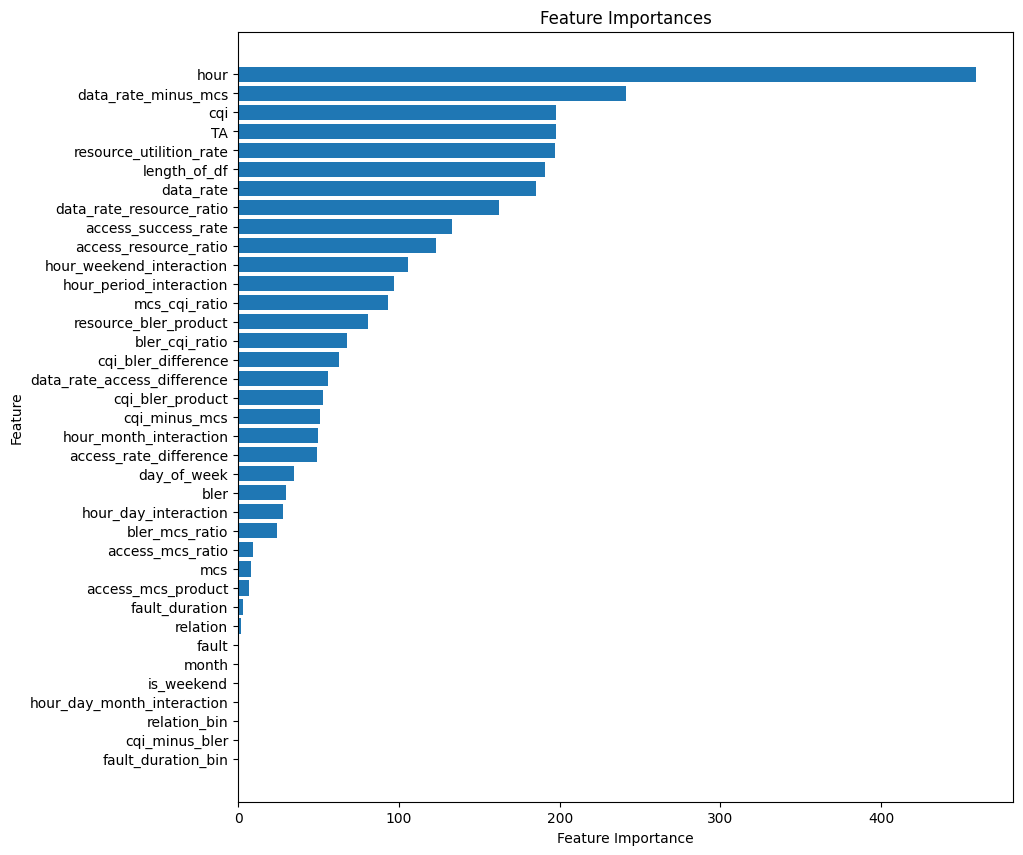

In [22]:
# Get the feature importances from the trained LightGBM model
feature_importances = model.feature_importances_

# Get the names of the features from the X_train columns
feature_names = train2.columns

# Create a DataFrame to store feature names and their corresponding importances
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})

# Sort the DataFrame based on feature importances in ascending order
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=True)

# Plot the feature importances using matplotlib
plt.figure(figsize=(10, 10))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Feature Importances')
plt.show()

#### CatBoost

In [ ]:
# Instantiate the CatBoostClassifier model
model = CatBoostClassifier(random_seed=seed, verbose=False,thread_count= 8)

# Fit the model on the training data
model.fit(train2, y)

# Predict probabilities of class 1 for the test data using the trained model
test_pred_proba = model.predict_proba(test[train2.columns])[:, 1]

# Adjust the threshold for classification based on probability values
test_predictions = (test_pred_proba >= 0.482).astype(int)

# Create a DataFrame to store predictions
predictions_df = pd.DataFrame({'ID': test["NE ID"], 'data_rate_t+1_trend': test_predictions})

# Save the predictions to a CSV file named "catboost.csv"
predictions_df.to_csv("catboost.csv", index=False)

# Display the value counts of predicted classes
print(predictions_df["data_rate_t+1_trend"].value_counts())

# Display the first few rows of the predictions DataFrame
predictions_df.head()

In [ ]:
# Get the feature importances from the trained LightGBM model
feature_importances = model.feature_importances_

# Get the names of the features from the X_train columns
feature_names = train2.columns

# Create a DataFrame to store feature names and their corresponding importances
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})

# Sort the DataFrame based on feature importances in ascending order
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=True)

# Plot the feature importances using matplotlib
plt.figure(figsize=(10, 10))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Feature Importances')
plt.show()

#### Ensembling

In [ ]:
# Read the model prediction CSV files
catboost = pd.read_csv("catboost.csv")
lgbm = pd.read_csv("lgbm.csv")

# Create an empty DataFrame for the ensemble predictions
ensemble = pd.DataFrame()

# Copy the 'ID' column from the 'catboost' DataFrame to the 'ensemble' DataFrame
ensemble["ID"] = catboost["ID"]

# Concatenate the 'data_rate_t+1_trend' columns from both models into a single DataFrame
predictions_data = pd.concat([catboost["data_rate_t+1_trend"], lgbm["data_rate_t+1_trend"]], axis=1)

# Calculate the sum of predictions from both models for each row
predictions_data["ensemble"] = predictions_data.iloc[:, 0] + predictions_data.iloc[:, 1]

# Update 'ensemble' column to 1 if the sum is greater than or equal to 1
predictions_data.loc[predictions_data["ensemble"] >= 1, "ensemble"] = 1

# Assign the 'ensemble' column to the 'data_rate_t+1_trend' column in the 'ensemble' DataFrame
ensemble["data_rate_t+1_trend"] = predictions_data["ensemble"]

# Display the value counts of the 'data_rate_t+1_trend' column in the ensemble predictions
print(ensemble["data_rate_t+1_trend"].value_counts())

# Save the ensemble predictions to a CSV file named 'ensemble.csv'
ensemble.to_csv('ensemble.csv', index=False)

# Display the first few rows of the ensemble predictions DataFrame
ensemble.head()

# END!!